# Phoneme Data Analysis

This notebook will analyze and clean the **phoneme dataset** which can be found at this [blog](https://machinelearningmastery.com/predictive-model-for-the-phoneme-imbalanced-classification-dataset/), for the usage in the models' comparison section of my masters' project.

Data description:

    The aim of this dataset is to distinguish between nasal (class 0) and oral sounds (class 1). Five different attributes were chosen to characterize each vowel: they are the amplitudes of the five first harmonics AHi, normalised by the total energy Ene (integrated on all the frequencies): AHi/Ene. The phonemes are transcribed as follows: sh as in she, dcl as in dark, iy as the vowel in she, aa as the vowel in dark, and ao as the first vowel in water.
    
Let's analyze the data.

## Dependencies

In [30]:
# Define the root path
import os
import sys
path = os.getcwd().split('tests')[0]
# Import the necessary libraries
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from imblearn.under_sampling import NearMiss
sns.set_style('darkgrid')
print(sns.__version__)

0.11.1


## Load the Data

In [2]:
df = pd.read_csv(path+'data/raw/phoneme.csv', names=['H1','H2','H3','H4','H5','target'])
df.head()

,H1,H2,H3,H4,H5,target
0,1.240,0.875,-0.205,-0.078,0.067,0
1,0.268,1.352,1.035,-0.332,0.217,0
2,1.567,0.867,1.300,1.041,0.559,0
3,0.279,0.990,2.555,-0.738,0.000,0
4,0.307,1.272,2.656,-0.946,-0.467,0


## How many samples and attribues?

In [3]:
print("Samples: {}".format(df.shape[0]))
print("Attributes: {}".format(df.shape[1]))

Samples: 5404
Attributes: 6


## Attributes Information

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5404 entries, 0 to 5403
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   H1      5404 non-null   float64
 1   H2      5404 non-null   float64
 2   H3      5404 non-null   float64
 3   H4      5404 non-null   float64
 4   H5      5404 non-null   float64
 5   target  5404 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 253.4 KB


All attributes are **floats** and there are no missing values.

## Attributes Description

In [5]:
df.describe()

,H1,H2,H3,H4,H5,target
count,5404.000000,5404.000000,5404.000000,5404.000000,5404.000000,5404.000000
mean,0.818957,1.258802,0.764732,0.398743,0.078619,0.293486
std,0.858733,0.851057,0.925436,0.796531,0.575624,0.455401
min,-1.700000,-1.327000,-1.823000,-1.581000,-1.284000,0.000000
25%,0.243750,0.596000,-0.115000,-0.205000,-0.232250,0.000000
50%,0.492500,1.075500,0.729000,0.285500,-0.044000,0.000000
75%,1.089250,1.866250,1.484000,0.937000,0.196250,1.000000
max,4.107000,4.378000,3.199000,2.826000,2.719000,1.000000


Now let's visualize the means of the attributes, so if ot is necessary to scale the data.

In [6]:
df_mean = pd.DataFrame(df.mean(),columns=['mean'])
df_mean

,mean
H1,0.818957
H2,1.258802
H3,0.764732
H4,0.398743
H5,0.078619
target,0.293486


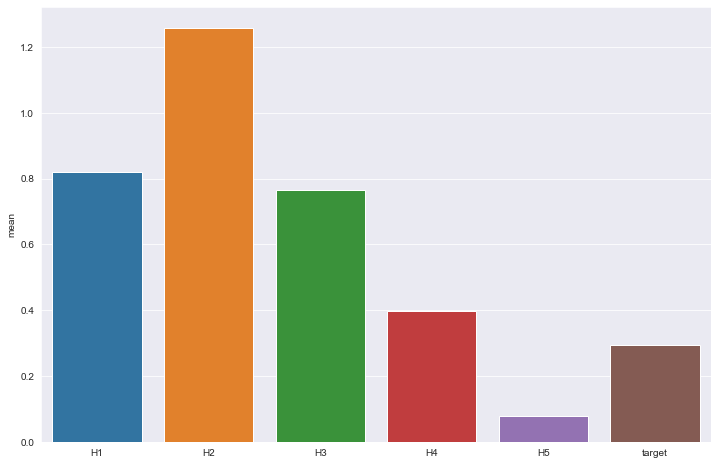

In [7]:
plt.figure(figsize=(12,8))
sns.barplot(data=df_mean,x=df_mean.index,y='mean')
sns.set_theme(font_scale=2)

No need to scale the data!

## There are duplicates?

In [8]:
df.duplicated().value_counts()

False    5349
True       55
dtype: int64

In [45]:
print("Percentage: {}%".format(round(df.duplicated().value_counts()[1]*100/df.shape[0],2)))

Percentage: 1.02%


There are about 1.02% of the dataset of duplicated data, so we will drop these samples.

<AxesSubplot:xlabel='target', ylabel='count'>

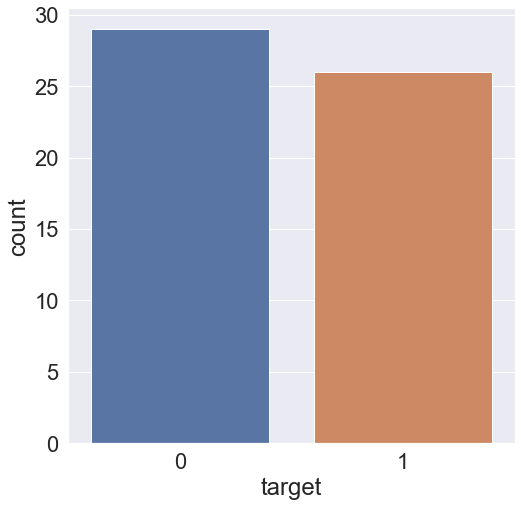

In [10]:
# Visualization of the duplicated data per target
dup = df.loc[df.duplicated()==True]
plt.figure(figsize=(8,8))
sns.countplot(x='target',data=dup)

There are so few data duplicated, and it's almost equally distributed between the classes

In [11]:
df_1 = df.drop_duplicates(keep='first')

In [12]:
df_1.reset_index(drop=True, inplace=True)
df_1.shape

(5349, 6)

## Proportion of the classes!

<AxesSubplot:xlabel='target', ylabel='count'>

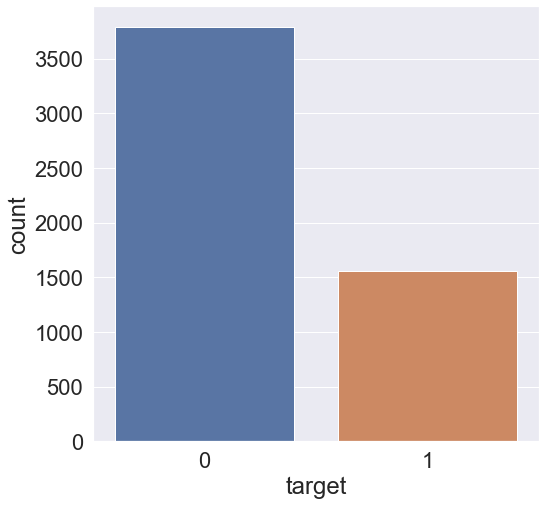

In [13]:
plt.figure(figsize=(8,8))
sns.countplot(x='target',data=df_1)

In [14]:
print("Class 0: {}".format(df_1.loc[df_1['target']==0].shape[0]*100/df_1.shape[0]))
print("Class 1: {}".format(df_1.loc[df_1['target']==1].shape[0]*100/df_1.shape[0]))

Class 0: 70.83567021873247
Class 1: 29.164329781267526


The dfference is that **70%** is of class 0, and **30%** of class 1. So we must balance this, but before balancing, we will make a scatter plot.

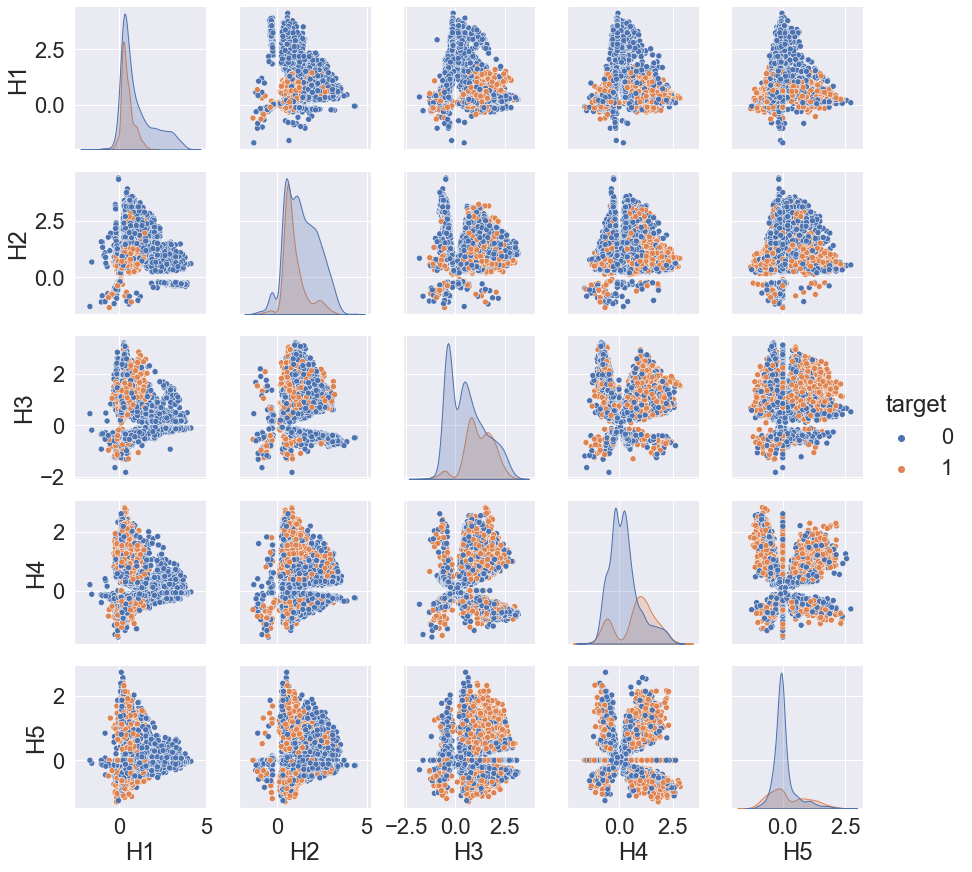

In [15]:
sns.pairplot(data=df_1,hue='target')

Now we will calculate the mahalanobis distance between all data points, this distance is a metric for finding outliers considering multivariate data.

In [16]:
import scipy as sp

cols = df_1.columns.values[:-1]
diff = df_1[cols] - df_1[cols].mean()
cov = df_1[cols].cov().values
try:
    chole = np.linalg.cholesky(cov)
except:
    print("Failed")
inv = sp.linalg.inv(cov)
left = diff.values@inv
mahal = left@diff.values.T
mahal = pd.DataFrame(mahal.diagonal(),columns=['mahalanobis'])
mahal.head()

,mahalanobis
0,2.229622
1,1.592314
2,3.588837
3,6.122153
4,8.373709


Now we will find the distance value where p-value < 5%

In [17]:
deg = df_1.shape[1]-1
value = sp.stats.chi2.ppf((1-0.05), df=deg)
value

11.070497693516351

Finally, we will find the values of mahalanobis distance that are higher than this threshold.

In [18]:
mahal[mahal['mahalanobis']>value].head()

,mahalanobis
33,11.410677
40,11.583127
64,16.596316
80,15.027126
117,12.898108


In [19]:
indexes = mahal[mahal['mahalanobis']>value].index
indexes

Int64Index([  33,   40,   64,   80,  117,  124,  153,  230,  294,  297,
            ...
            5158, 5163, 5207, 5220, 5260, 5265, 5280, 5284, 5308, 5334],
           dtype='int64', length=256)

So there 256 samples that are outliers.

In [20]:
df_outlier = df_1.loc[indexes,df_1.columns.values]
df_outlier.head()

,H1,H2,H3,H4,H5,target
33,0.747,1.029,1.346,-0.998,1.722,1
40,3.386,-0.301,0.136,-0.078,-0.055,0
64,-0.073,-0.250,-0.445,1.539,-1.184,1
80,0.081,0.309,0.445,-0.697,1.824,0
117,0.350,0.585,0.907,2.188,1.632,1


Now, let's count the outliers per targets and find their percentage.

<AxesSubplot:xlabel='target', ylabel='count'>

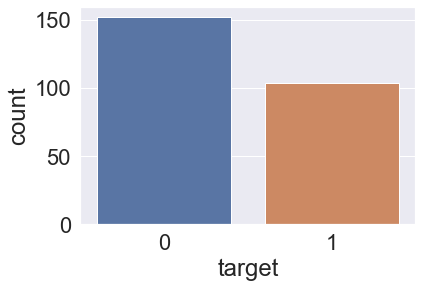

In [21]:
sns.countplot(data=df_outlier,x='target')

In [22]:
df_outlier['target'].value_counts()*100/df_outlier.shape[0]

0    59.375
1    40.625
Name: target, dtype: float64

The distribution is almost equal. Now let's drop these outliers.

In [23]:
df_new = df_1.drop(index=indexes)
df_new.reset_index(drop=True, inplace=True)
df_new

,H1,H2,H3,H4,H5,target
0,1.240,0.875,-0.205,-0.078,0.067,0
1,0.268,1.352,1.035,-0.332,0.217,0
2,1.567,0.867,1.300,1.041,0.559,0
3,0.279,0.990,2.555,-0.738,0.000,0
4,0.307,1.272,2.656,-0.946,-0.467,0
...,...,...,...,...,...,...
5088,0.254,2.392,0.689,1.828,-0.544,0
5089,0.781,1.250,0.793,0.383,0.816,1
5090,1.031,0.584,1.866,1.532,-0.671,1
5091,0.150,0.933,2.363,-0.742,-0.617,0


Let's plot the scatter matrix and calculate the skewness and kurtosis of the data distribution, to chec if the data is now close to a normal distribution.

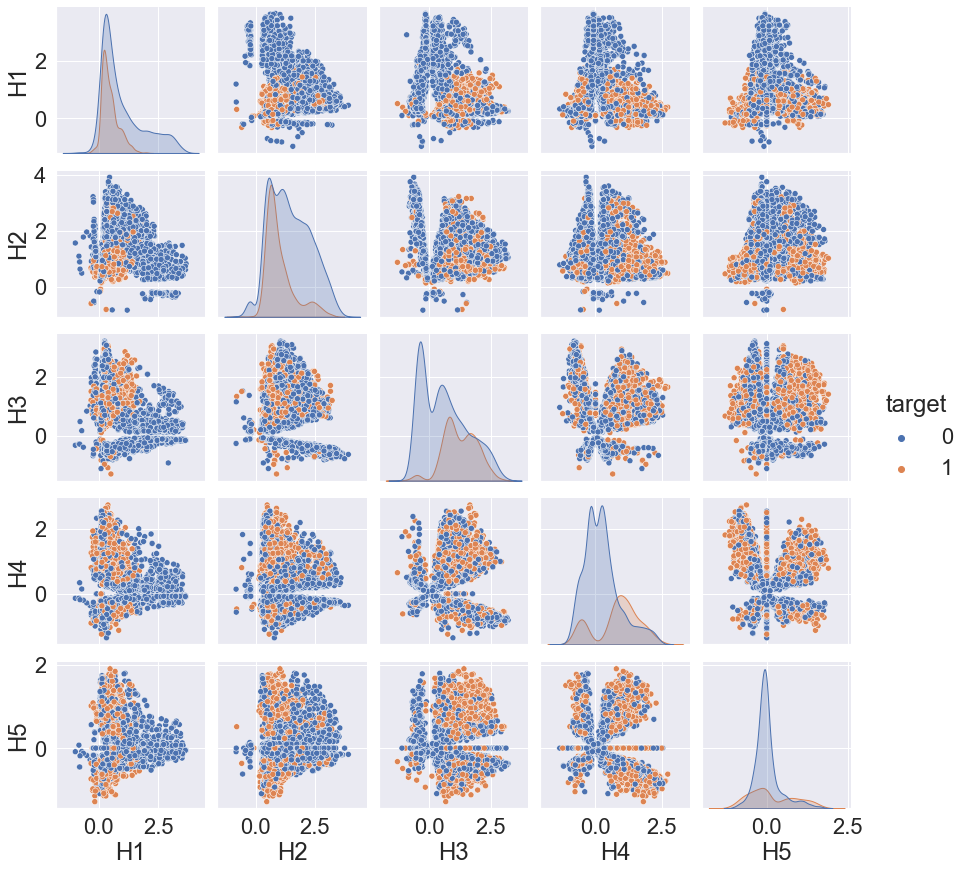

In [24]:
sns.pairplot(data=df_new,hue='target')

In [25]:
skew = df_new.skew()
skew[skew>1].sort_values(ascending=False)

H1    1.457650
H5    1.032955
dtype: float64

In [26]:
skew[skew<-1].sort_values()

Series([], dtype: float64)

In [27]:
kurt = df_new.kurtosis()
kurt

H1        1.348762
H2       -0.515830
H3       -0.898861
H4       -0.446540
H5        1.129668
target   -1.101634
dtype: float64

It's better than before.

Let's resample!

In [28]:
df_y = df_new['target']
df_x = df_new[df_new.columns.values[:-1]]

In [32]:
x_resample, y_resample = NearMiss(version=2).fit_resample(df_x, df_y)


In [33]:
x_resample.shape

(2912, 5)

In [34]:
y_resample.shape

(2912,)

And save it as dataframe

In [35]:
df_sample = pd.concat([x_resample,y_resample],axis=1)

Now let's visualize the data distrbution in a satter matrix and in a kde matrix.

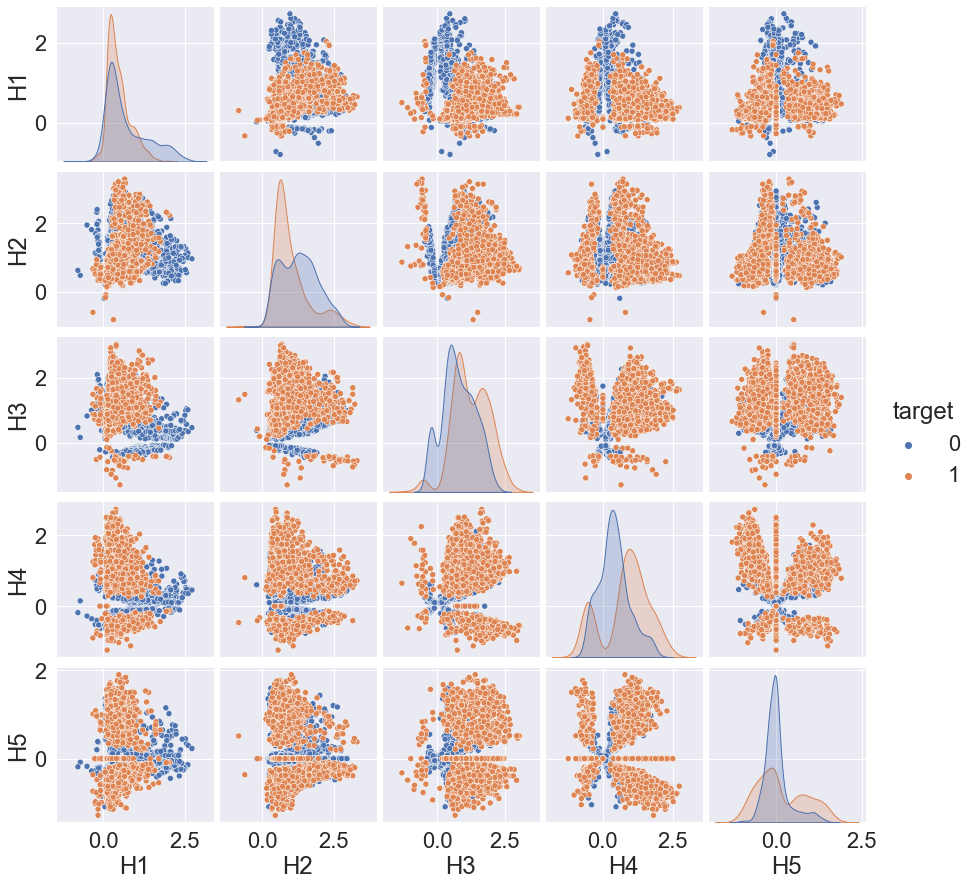

In [36]:
sns.pairplot(data=df_sample,hue='target')

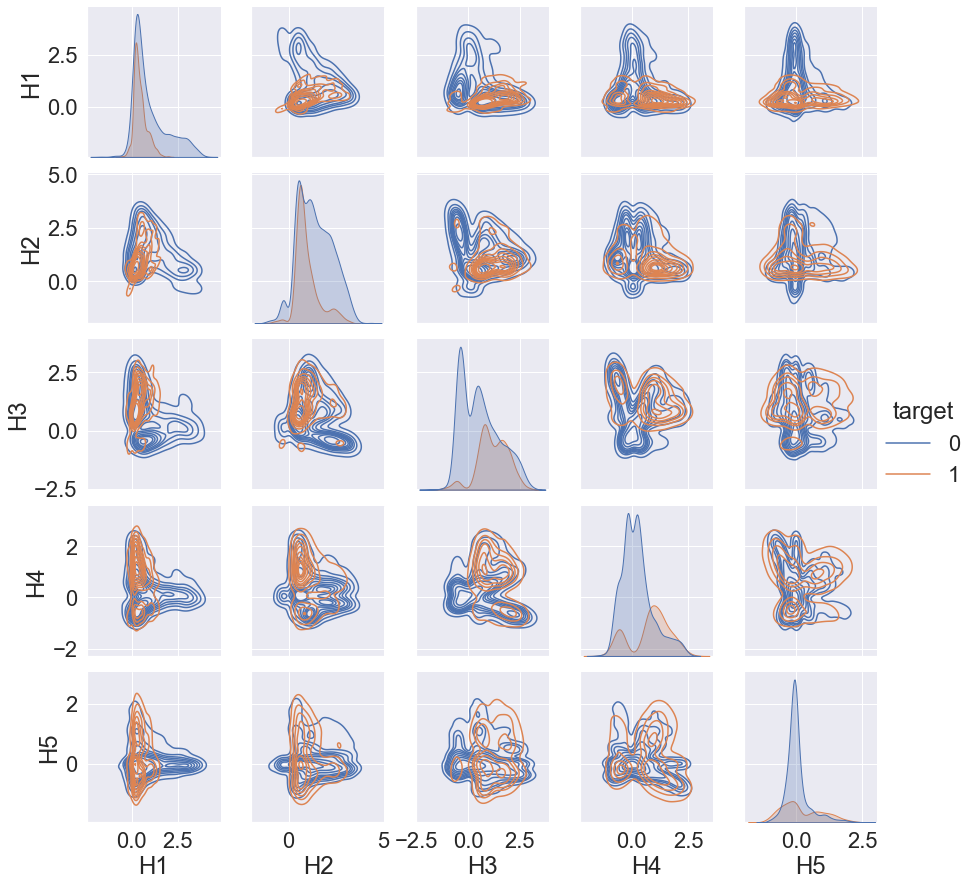

In [46]:
sns.pairplot(data=df,hue='target',kind='kde')

Let's measure the skewness and kurtosis.

In [37]:
skew = df_sample.skew()
skew[skew>1].sort_values(ascending=False)

H1    1.393594
dtype: float64

In [38]:
skew[skew<-1].sort_values()

Series([], dtype: float64)

In [39]:
kurt = df_sample.kurtosis()
kurt

H1        1.560704
H2       -0.124316
H3       -0.309370
H4       -0.575263
H5        0.195807
target   -2.001375
dtype: float64

Finally, we will change the target values from 0 and 1, to 1 and 2, respectively.

In [40]:
df_sample['target']+=1

In [41]:
df_sample

,H1,H2,H3,H4,H5,target
0,0.267,1.344,0.978,0.492,-0.160,1
1,0.334,1.312,0.990,0.464,-0.201,1
2,0.419,1.303,0.851,0.463,-0.148,1
3,0.404,1.284,0.837,0.448,-0.135,1
4,0.392,1.443,1.052,0.423,0.000,1
...,...,...,...,...,...,...
2907,0.293,1.106,0.792,2.263,-0.624,2
2908,0.653,1.061,2.321,1.546,-0.401,2
2909,0.781,1.250,0.793,0.383,0.816,2
2910,1.031,0.584,1.866,1.532,-0.671,2


Let's save the dataset!

In [80]:
df_sample.to_csv(path+'data/cleaned/phoneme.csv', index=False)